In [1]:
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier

# some PCA and GMM stuff
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

import sklearn.ensemble as ske
from sklearn.feature_selection import SelectFromModel

In [7]:
#train_file = 'https://people.ischool.berkeley.edu/~andrew.morris/data/w209/train.csv'
#test_file = 'https://people.ischool.berkeley.edu/~andrew.morris/data/w209/test.csv'
#train_file = 'data/mini_train.csv'
train_file = 'data/train_data_clean.csv'
train_id_file = 'data/train_ids.csv'
train_label_file = 'data/train_labels.csv'

#dev_file = 'data/mini_dev.csv'
#test_file = 'data/test.csv'

In [3]:
dtypes = {
        'MachineIdentifier':                                    'str',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float64', 
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32', 
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float32', 
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float64', 
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float64', 
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', 
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', 
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32', 
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float64', 
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [36]:
def reduce_mem(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [29]:
train_df = pd.read_csv(train_file)#, dtype=dtypes)
#test_df = pd.read_csv(test_file, dtype=dtypes)

In [77]:
train_labels = pd.read_csv(train_label_file)#, dtype=dtypes) #train_df['HasDetections']
train_ids = pd.read_csv(train_id_file)#, dtype=dtypes) #train_df['MachineIdentifier']
train_data = train_df #.drop(columns=['HasDetections', 'MachineIdentifier'])

In [79]:
train_labels = reduce_mem(train_labels)["HasDetections"]
train_ids = reduce_mem(train_ids)["MachineIdentifier"]
train_data = reduce_mem(train_data)

Memory usage of dataframe is 136.13 MB
Memory usage after optimization is: 456.13 MB
Decreased by -235.1%


In [84]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 97 columns):
Unnamed: 0                                           int32
ProductName                                          int8
IsBeta                                               int8
IsSxsPassiveMode                                     int8
DefaultBrowsersIdentifier                            int16
AVProductStatesIdentifier                            int32
AVProductsInstalled                                  int8
AVProductsEnabled                                    int8
HasTpm                                               int8
CountryIdentifier                                    int16
CityIdentifier                                       int32
OrganizationIdentifier                               int8
GeoNameIdentifier                                    int16
LocaleEnglishNameIdentifier                          int16
Platform                                             int8
Processor 

In [10]:
#test_ids = test_df['MachineIdentifier']
#test_data = test_df.drop(columns=['MachineIdentifier'])

In [11]:
#test_data.info()

In [12]:
#all_data = pd.concat((test_data,train_data), axis=0)

In [39]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = [c for c,v in train_data.dtypes.items() if v in numerics and c in train_data.columns]

In [41]:
nominal_cols = [c for c in train_data.columns if (c not in numeric_cols)]

In [43]:
binary_cols = [c for c in train_data.columns if (train_data[c].nunique() == 2 and c not in nominal_cols)]

In [45]:
continuous_cols = [c for c in numeric_cols if (c not in binary_cols)]

In [47]:
# Additional encoding TBD
print("Columns to review NaN values:")
train_data.isna().any()[lambda x: x]

Columns to review NaN values:


Series([], dtype: bool)

In [18]:
# Let's get a feeling for range of values in the nominal categories

In [48]:
train_data[nominal_cols].describe().transpose()

,count,unique,top,freq
ProductName,8921483,6,win8defender,8826520
Platform,8921483,4,windows10,8618715
Processor,8921483,3,x64,8105435
OsVer,8921483,58,10.0.0.0,8632545
OsPlatformSubRelease,8921483,9,rs4,3915526
OsBuildLab,8921483,664,17134.1.amd64fre.rs4_release.180410-1804,3658199
SkuEdition,8921483,8,Home,5514341
PuaMode,8921483,3,unknown,8919174
SmartScreen,8921483,22,RequireAdmin,4316183
Census_MDC2FormFactor,8921483,13,Notebook,5723319


In [50]:
# Encode nominal variables as labeled strings
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for i, col in enumerate(nominal_cols):
    train_data[col] = encoder.fit_transform(train_data[col].astype(str))
    #test_data[col] = encoder.fit_transform(test_data[col].astype(str))

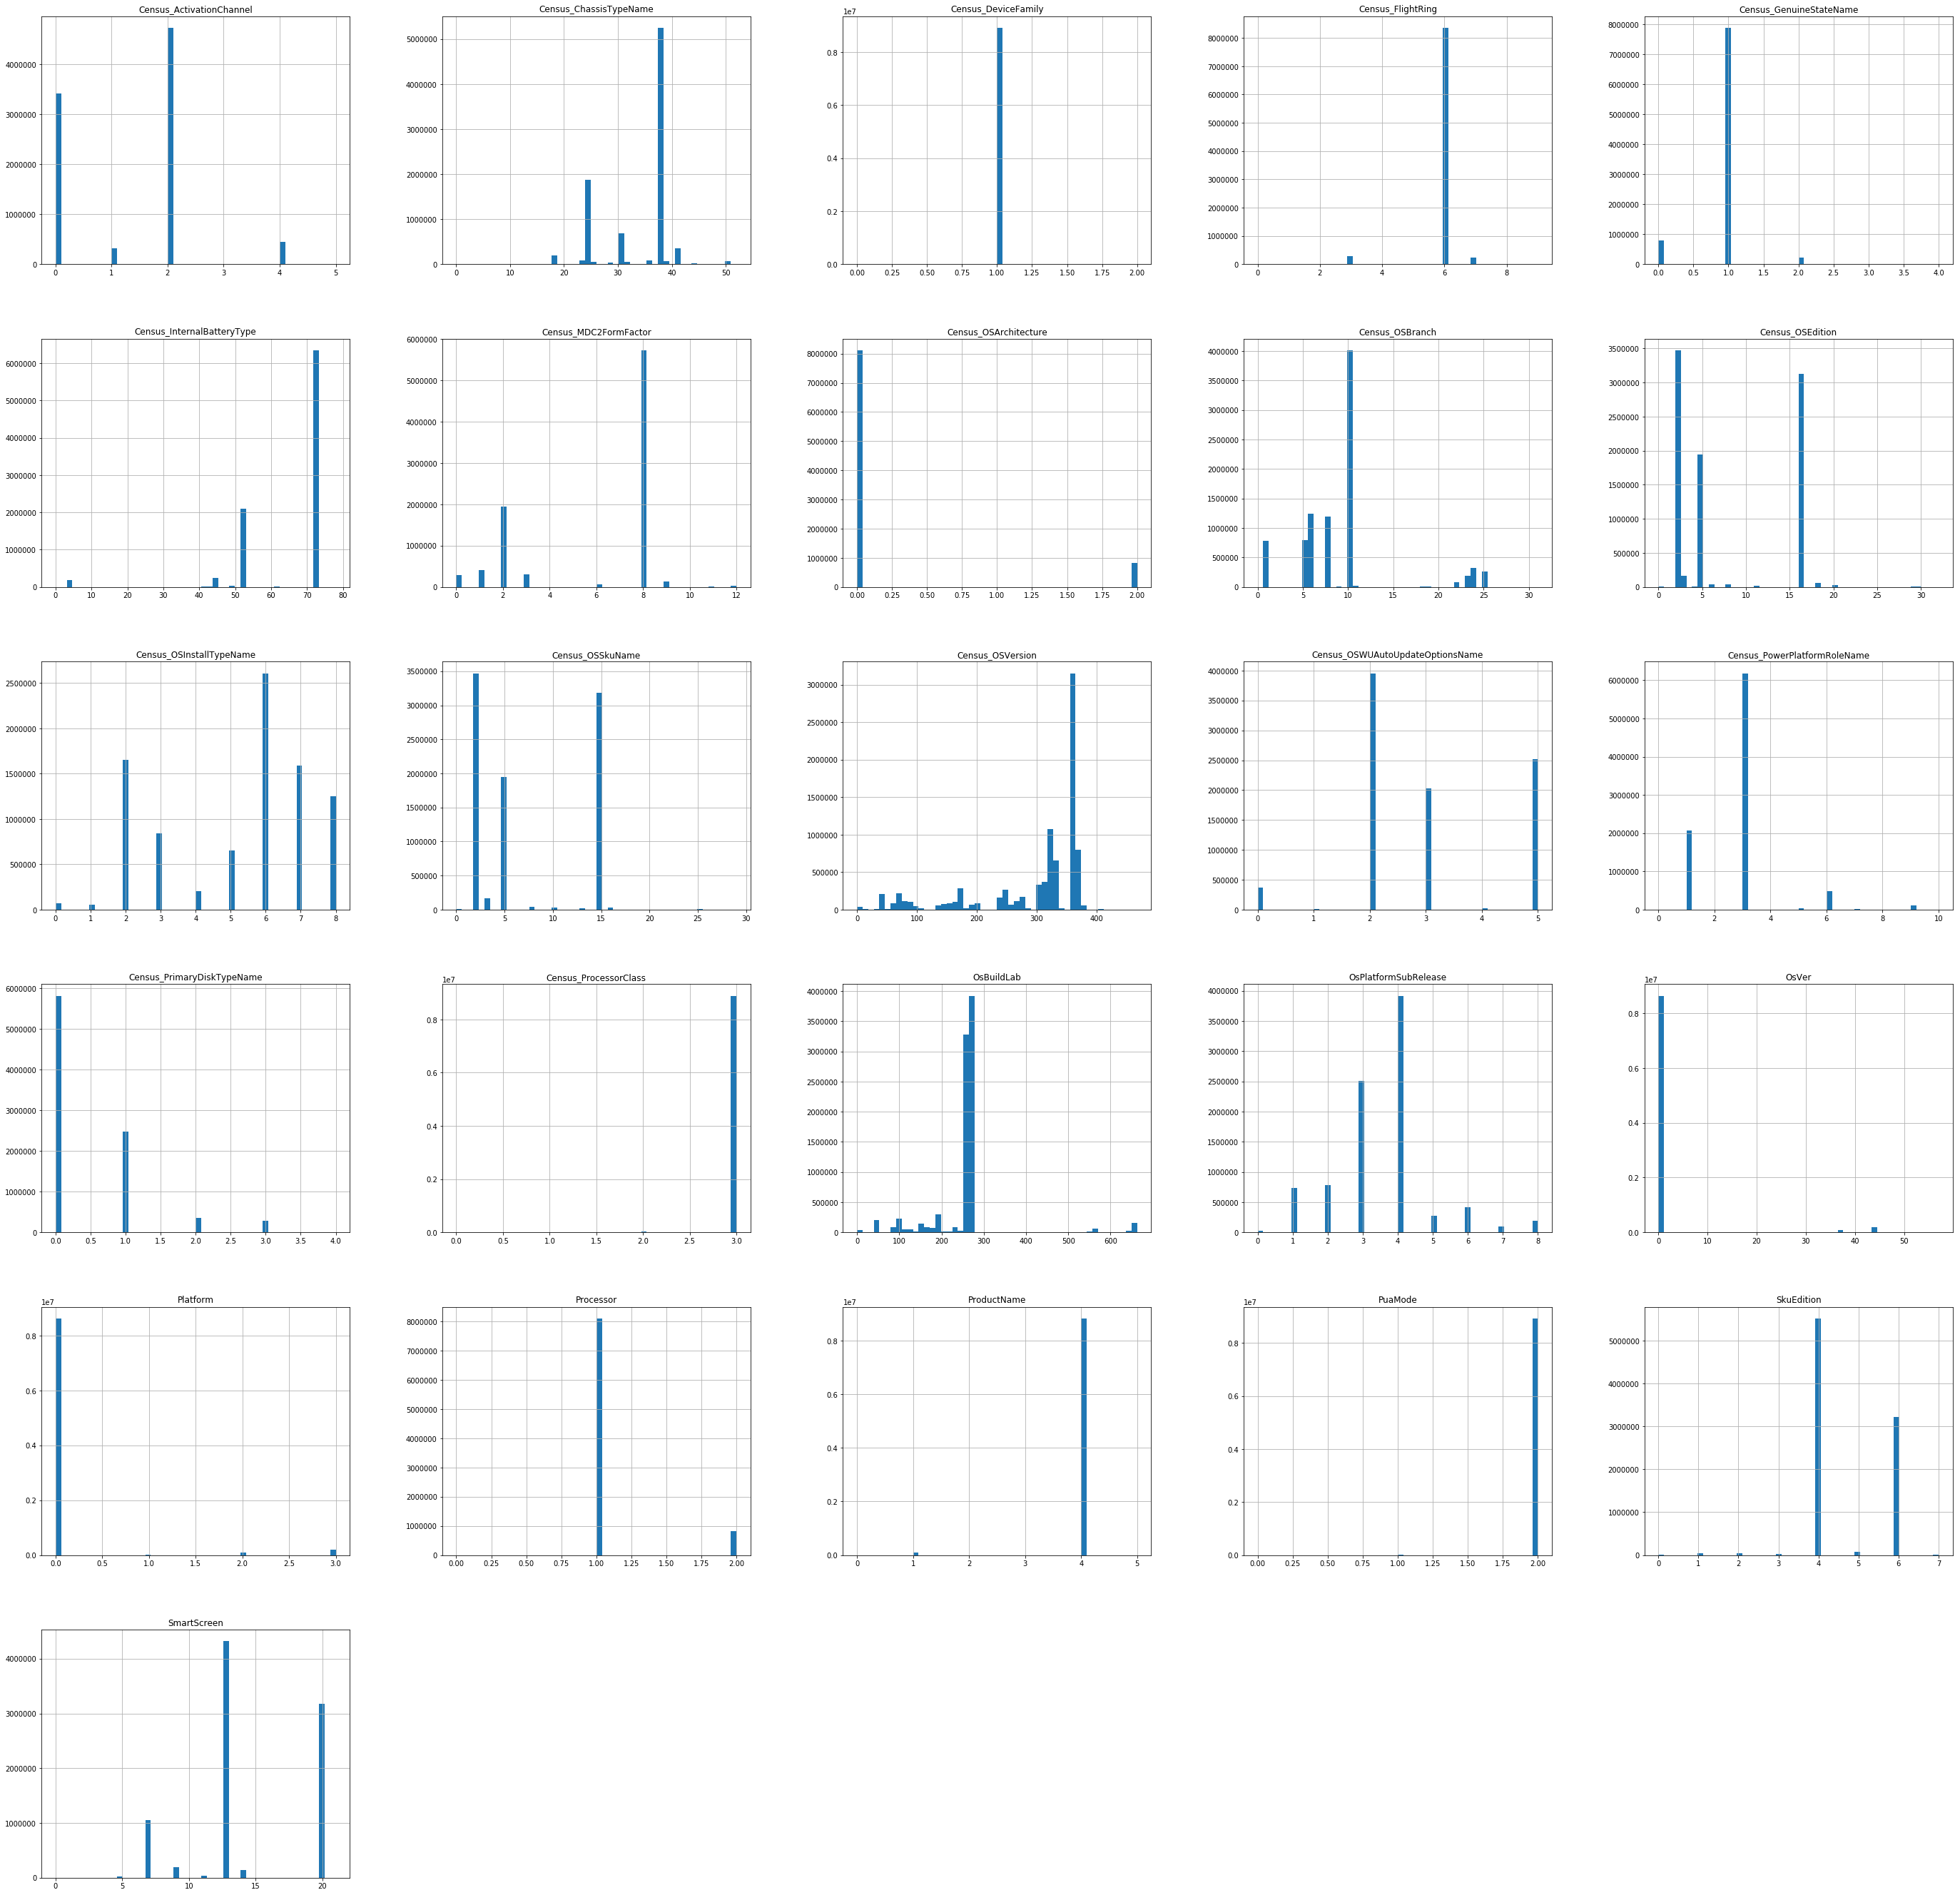

In [51]:
train_data[nominal_cols].hist(figsize=(48,48), bins=50)
plt.show()

In [52]:
for i, col in enumerate(nominal_cols):
    print('The number of values for {:} = {:}'.format(col, (len(list(train_data[col].unique())))))

The number of values for ProductName = 6
The number of values for Platform = 4
The number of values for Processor = 3
The number of values for OsVer = 58
The number of values for OsPlatformSubRelease = 9
The number of values for OsBuildLab = 664
The number of values for SkuEdition = 8
The number of values for PuaMode = 3
The number of values for SmartScreen = 22
The number of values for Census_MDC2FormFactor = 13
The number of values for Census_DeviceFamily = 3
The number of values for Census_ProcessorClass = 4
The number of values for Census_PrimaryDiskTypeName = 5
The number of values for Census_ChassisTypeName = 53
The number of values for Census_PowerPlatformRoleName = 11
The number of values for Census_InternalBatteryType = 79
The number of values for Census_OSVersion = 469
The number of values for Census_OSArchitecture = 3
The number of values for Census_OSBranch = 32
The number of values for Census_OSEdition = 33
The number of values for Census_OSSkuName = 30
The number of value

In [87]:
correlated_cols = []
for i, col in enumerate(nominal_cols):
    corr = train_labels.corr(train_data[col])
    if(corr > 0.05  or corr < -0.05):
        star='(*)' # flag the highly correlated nominal variables
        correlated_cols.append(col)
    else:
        star=''
    print('The correlation of {:} with the outcome variable is {:7.6f}{:}'.format(col, corr, star))

The correlation of ProductName with the outcome variable is 0.003182
The correlation of Platform with the outcome variable is -0.000284
The correlation of Processor with the outcome variable is -0.073186(*)
The correlation of OsVer with the outcome variable is 0.000414
The correlation of OsPlatformSubRelease with the outcome variable is 0.018257
The correlation of OsBuildLab with the outcome variable is 0.016147
The correlation of SkuEdition with the outcome variable is 0.017545
The correlation of PuaMode with the outcome variable is -0.007627
The correlation of SmartScreen with the outcome variable is -0.119648(*)
The correlation of Census_MDC2FormFactor with the outcome variable is -0.009723
The correlation of Census_DeviceFamily with the outcome variable is -0.012078
The correlation of Census_ProcessorClass with the outcome variable is -0.005741
The correlation of Census_PrimaryDiskTypeName with the outcome variable is -0.026525
The correlation of Census_ChassisTypeName with the out

In [54]:
train_data[continuous_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,8921483.0,4.460741e+06,2.575410e+06,0.0,2230370.5,4460741.0,6691111.5,8921482.0
DefaultBrowsersIdentifier,8921483.0,8.056892e+01,4.190503e+02,0.0,0.0,0.0,0.0,3213.0
AVProductStatesIdentifier,8921483.0,4.764578e+04,1.433046e+04,0.0,49480.0,53447.0,53447.0,70507.0
AVProductsInstalled,8921483.0,1.317332e+00,5.424331e-01,-1.0,1.0,1.0,2.0,7.0
AVProductsEnabled,8921483.0,1.012762e+00,2.108918e-01,-1.0,1.0,1.0,1.0,5.0
CountryIdentifier,8921483.0,1.080490e+02,6.304706e+01,1.0,51.0,97.0,162.0,222.0
CityIdentifier,8921483.0,7.830232e+04,5.038158e+04,-1.0,31276.0,77866.0,121270.0,167962.0
OrganizationIdentifier,8921483.0,1.688779e+01,1.282279e+01,-1.0,-1.0,18.0,27.0,52.0
GeoNameIdentifier,8921483.0,1.696575e+02,8.932096e+01,-1.0,89.0,181.0,267.0,296.0
LocaleEnglishNameIdentifier,8921483.0,1.228161e+02,6.932125e+01,1.0,74.0,88.0,182.0,283.0


In [ ]:
# Andrew's temporary draft for StandardScaler.  Pasting in Kevin's variation, as well:

#inverse_cols = [i for i in train_data.columns if i not in numeric_cols]
#features = train_data[numeric_cols]
#ct = ColumnTransformer([('transform', StandardScaler(), numeric_cols)], remainder='passthrough')
#ct.fit_transform(features)
#train_data_scaled = pd.DataFrame(features, index=train_data.index, columns=numeric_cols)
#inverse_data = pd.DataFrame(train_data[inverse_cols], index=train_data.index, columns=inverse_cols)
#frames = [train_data_scaled, inverse_data]
#train_data2 = pd.concat(frames, sort=False)
#train_data2.describe()

# Kevin's version:
#for i, col in enumerate(numeric_cols):
#    standard_scaler = StandardScaler().fit(train_data[col])
#    train_data[col] = standard_scaler.transform(train_data[col])



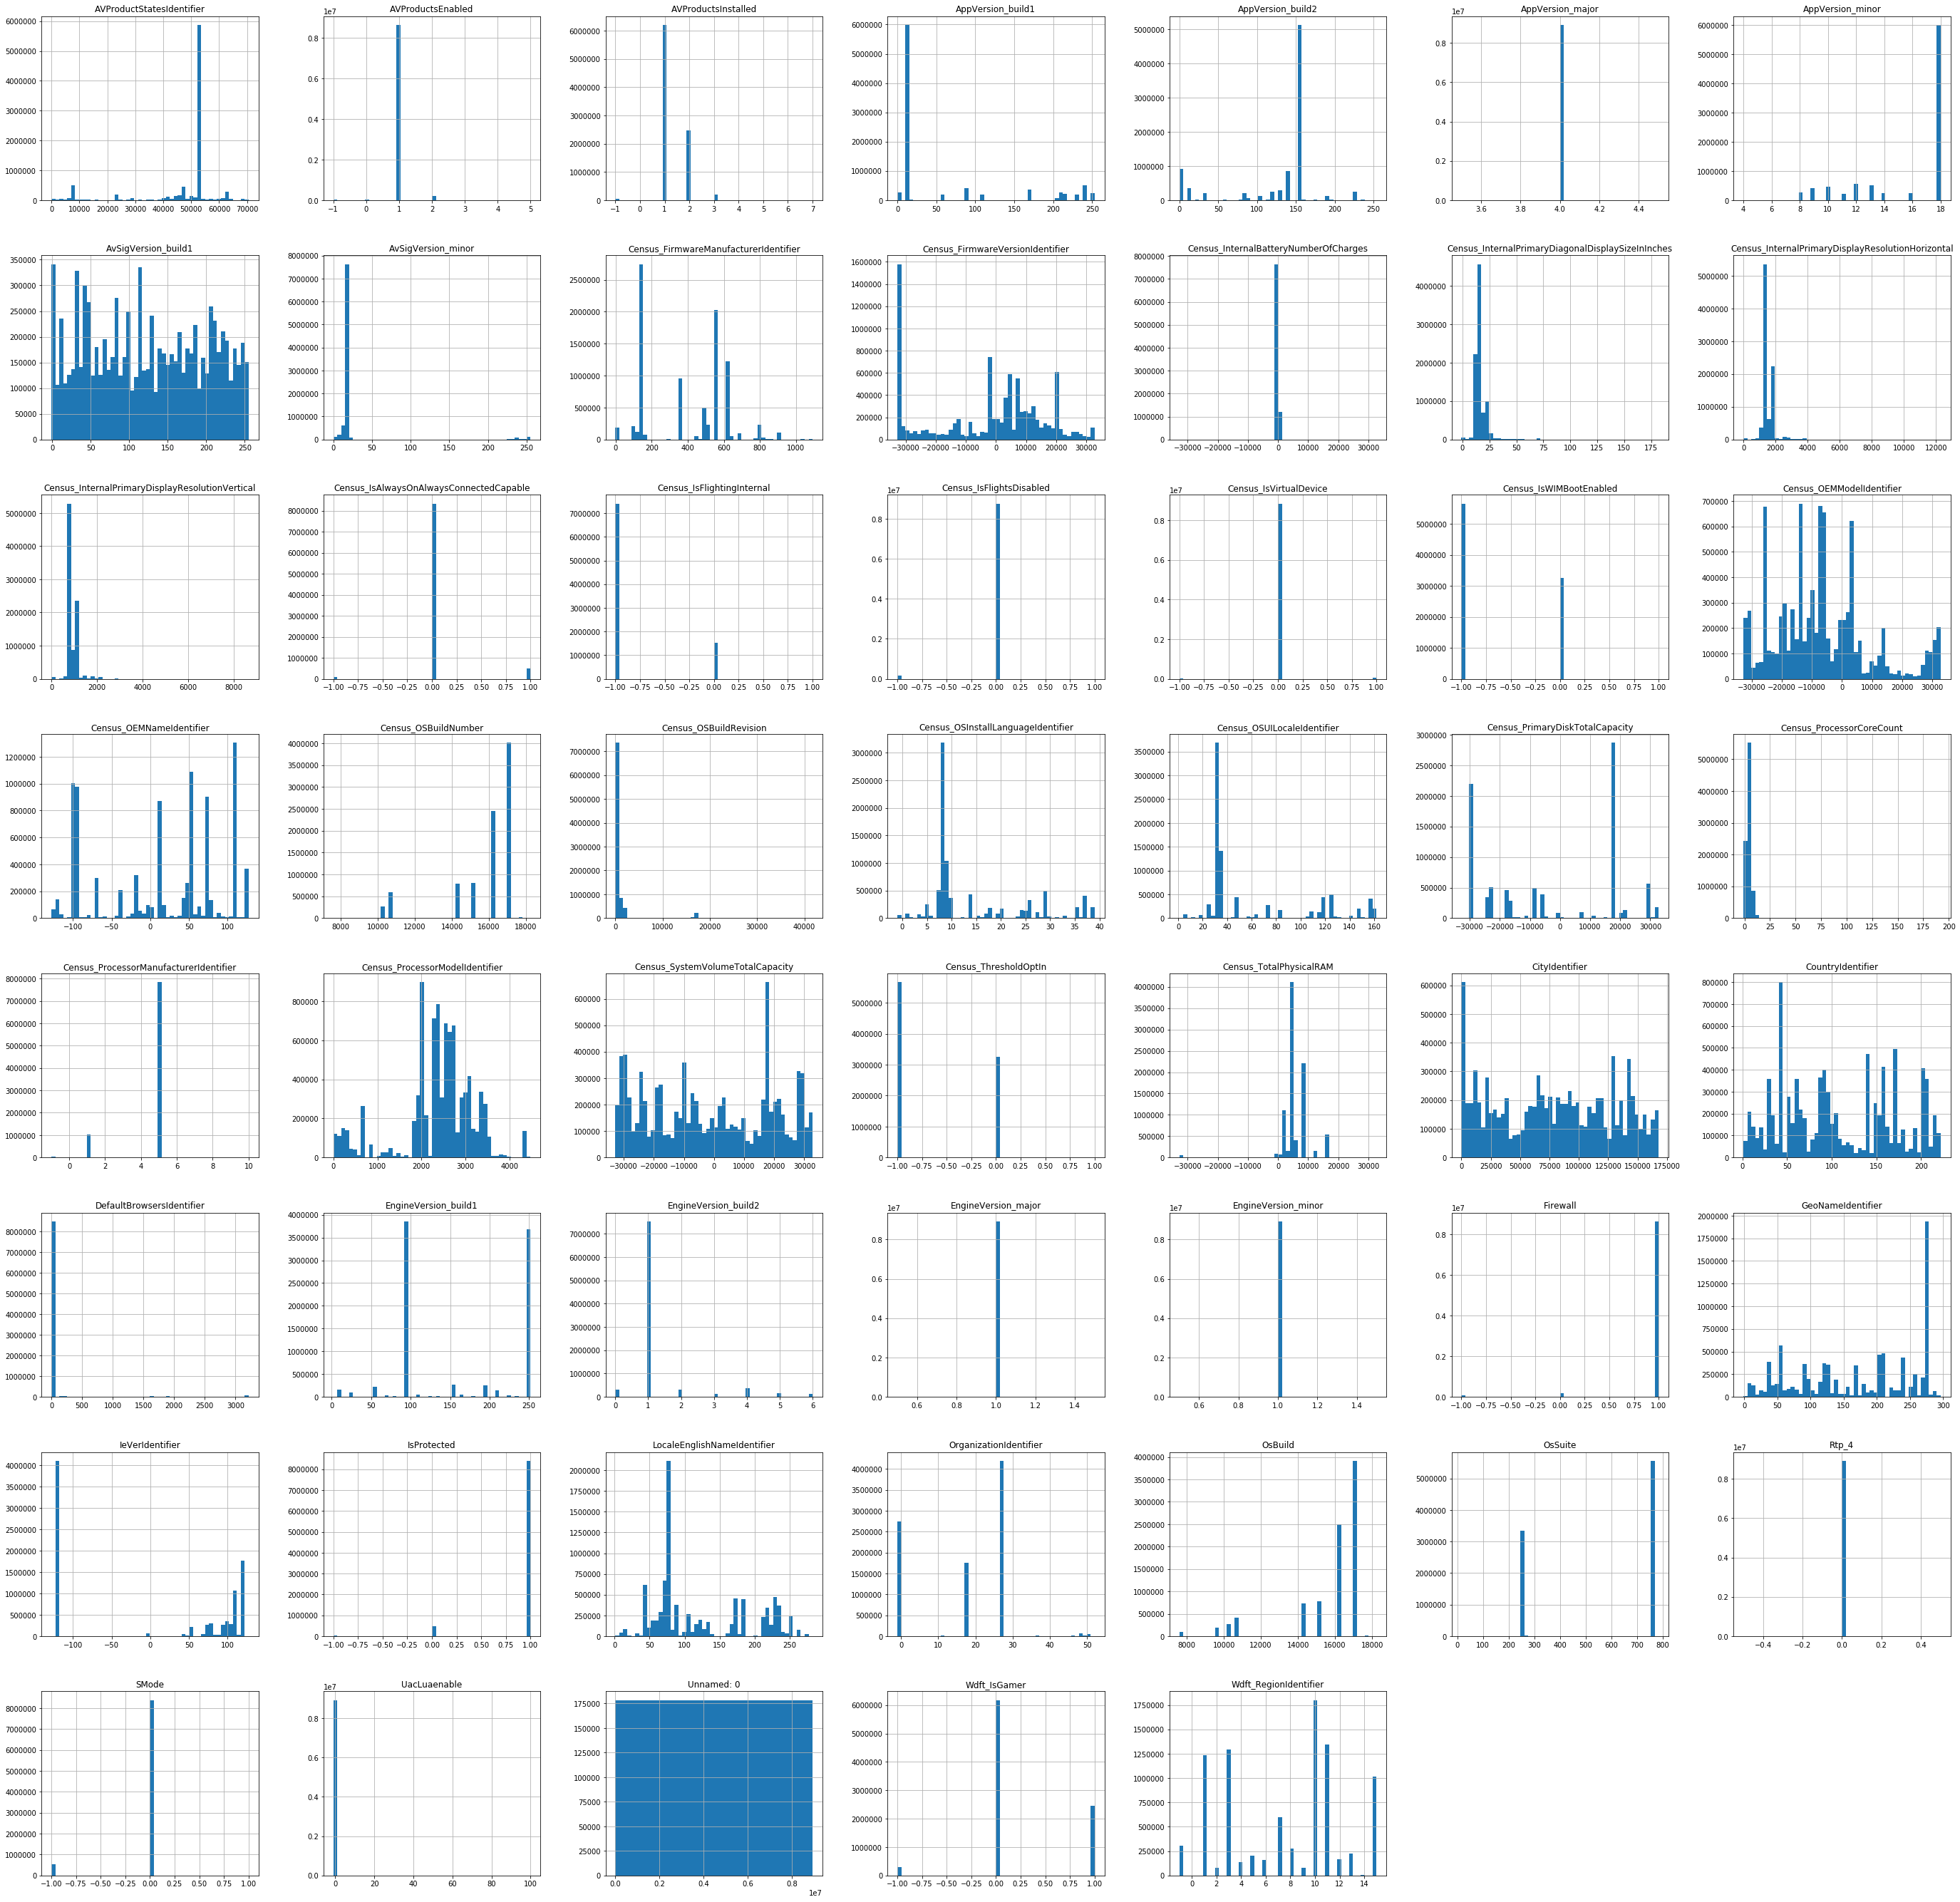

In [55]:
train_data[continuous_cols].hist(figsize=(48,48), bins=50)
plt.show()

In [56]:
train_data[binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
IsBeta,8921483.0,7.509962e-06,0.002740,0.0,0.0,0.0,0.0,1.0
IsSxsPassiveMode,8921483.0,1.733378e-02,0.130512,0.0,0.0,0.0,0.0,1.0
HasTpm,8921483.0,9.879711e-01,0.109015,0.0,1.0,1.0,1.0,1.0
AutoSampleOptIn,8921483.0,2.891896e-05,0.005378,0.0,0.0,0.0,0.0,1.0
Census_HasOpticalDiskDrive,8921483.0,7.718728e-02,0.266888,0.0,0.0,0.0,0.0,1.0
Census_IsPortableOperatingSystem,8921483.0,5.452008e-04,0.023343,0.0,0.0,0.0,0.0,1.0
Census_IsSecureBootEnabled,8921483.0,4.860229e-01,0.499805,0.0,0.0,0.0,1.0,1.0
Census_IsTouchEnabled,8921483.0,1.255431e-01,0.331334,0.0,0.0,0.0,0.0,1.0
Census_IsPenCapable,8921483.0,3.807091e-02,0.191368,0.0,0.0,0.0,0.0,1.0
Rtp_NaN,8921483.0,3.641129e-03,0.059937,0.0,0.0,0.0,0.0,1.0


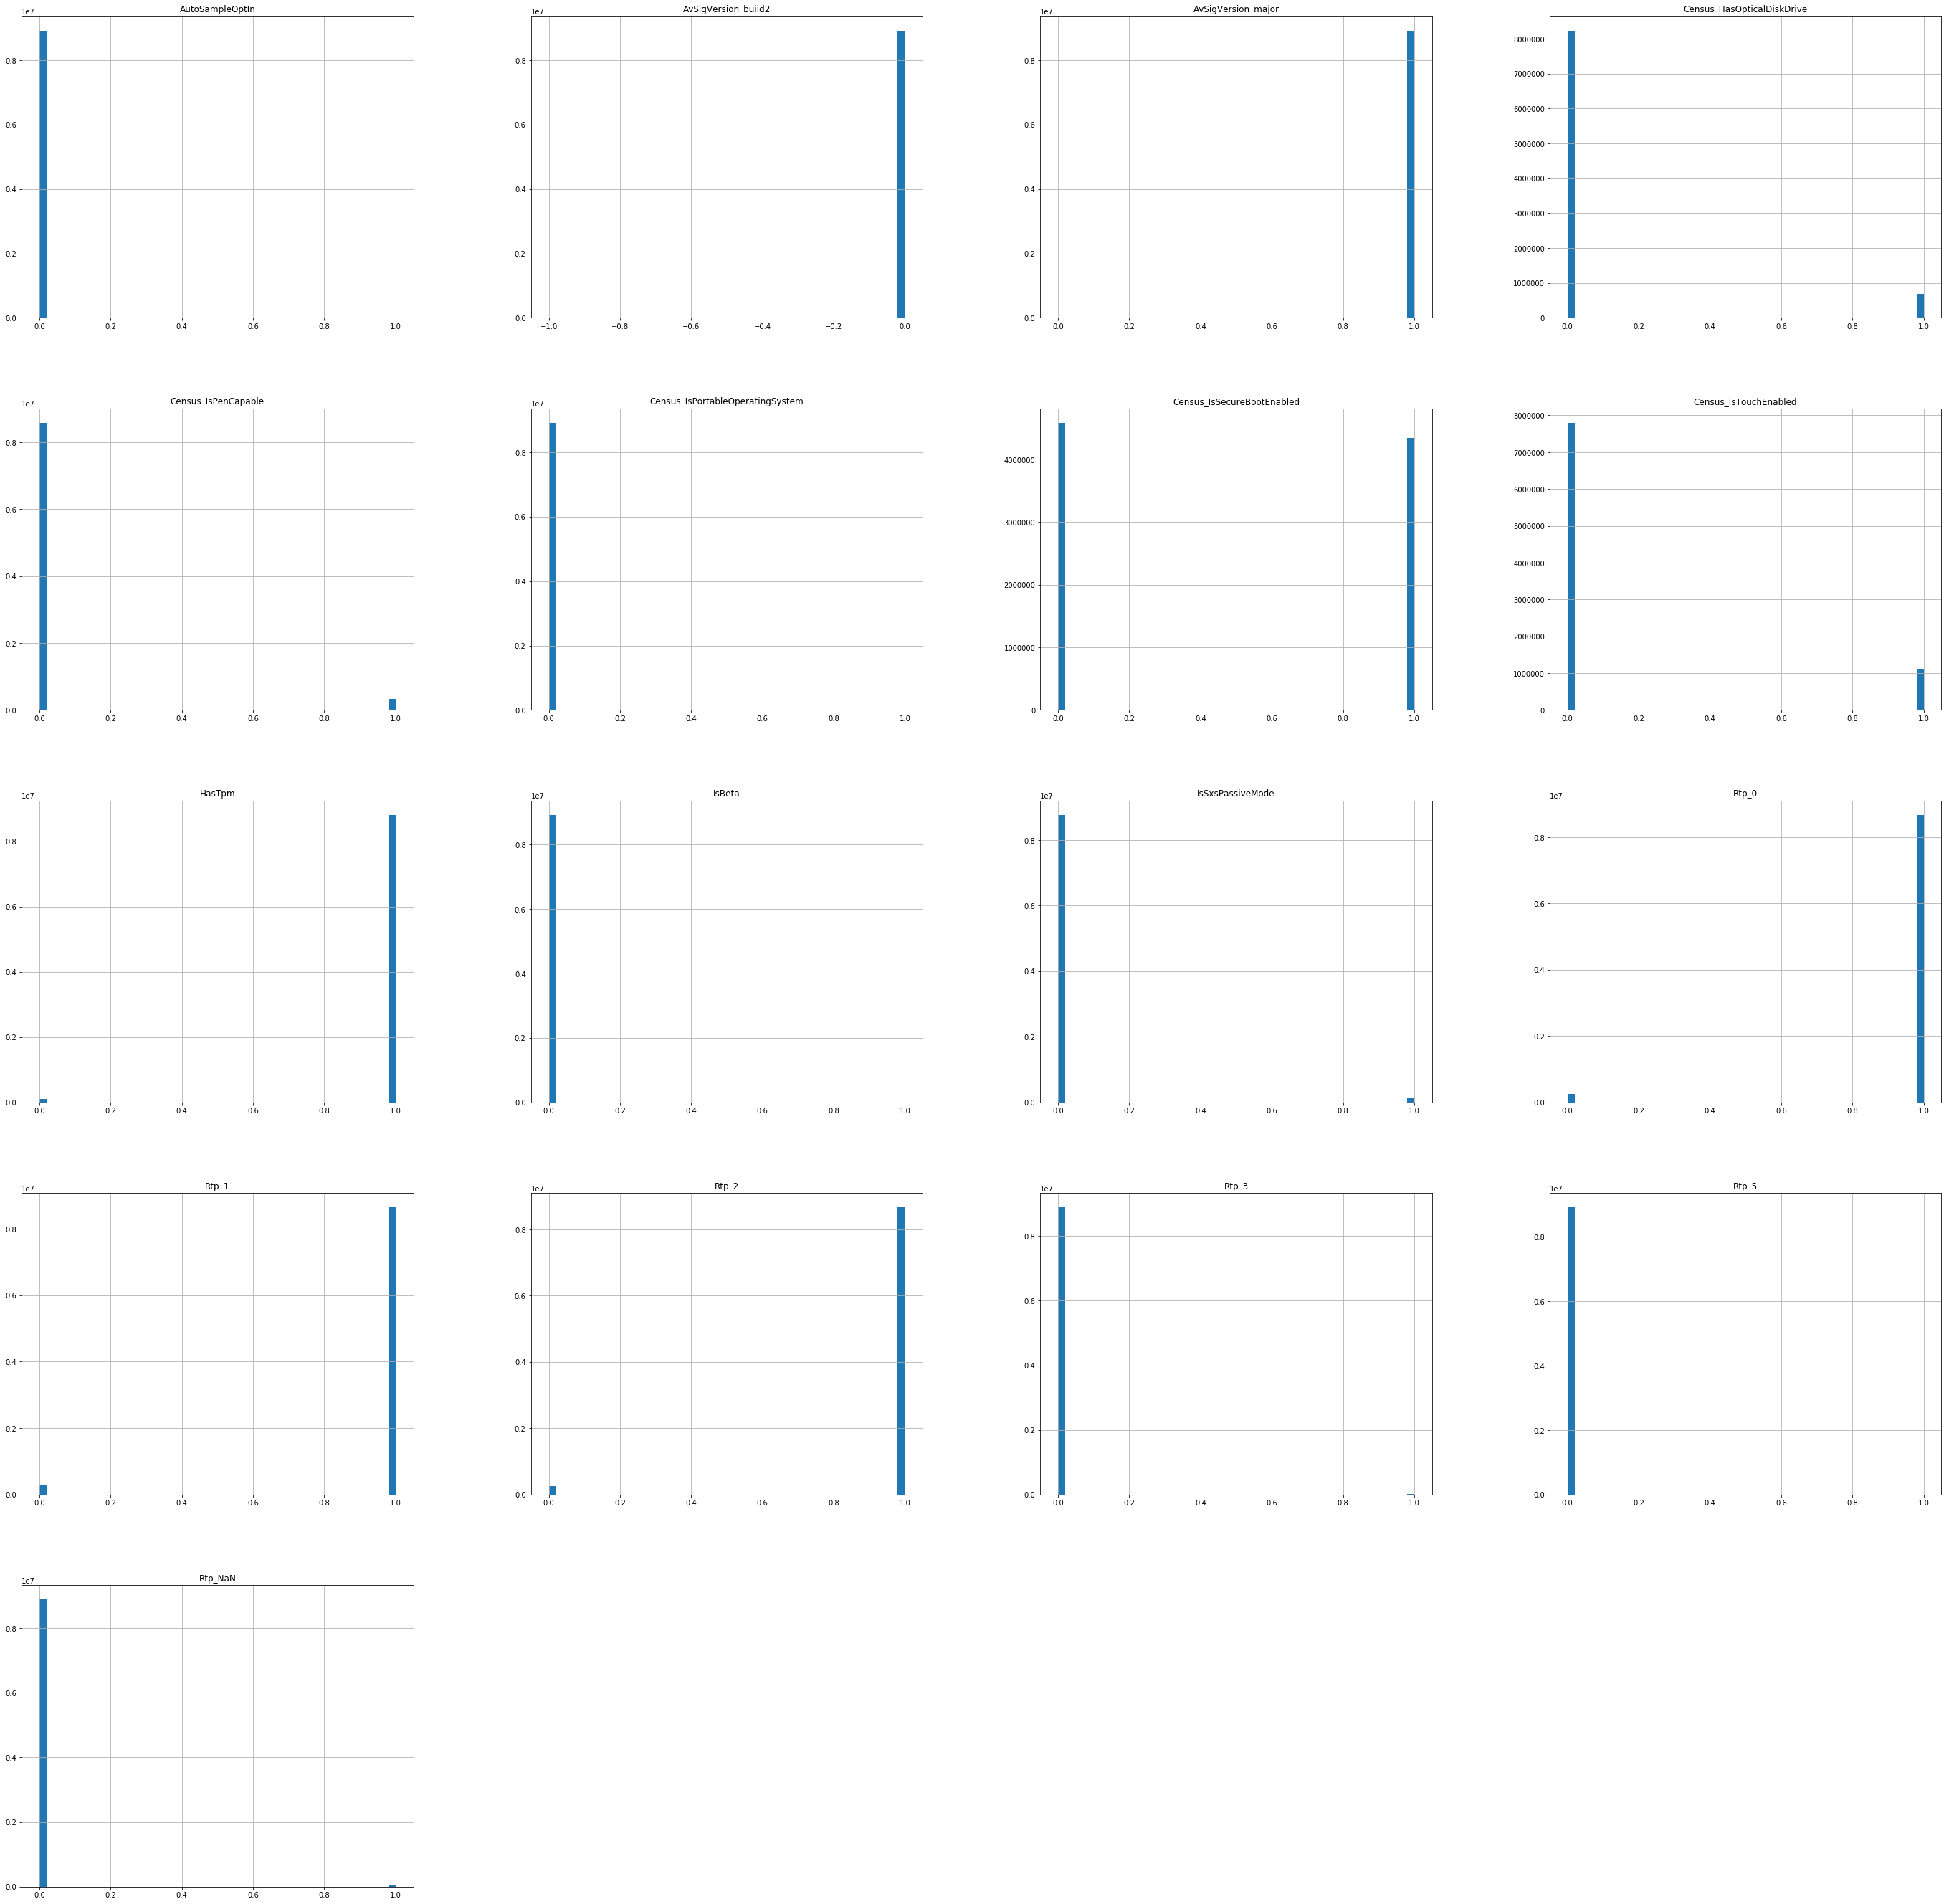

In [57]:
train_data[binary_cols].hist(figsize=(48,48), bins=50)
plt.show()

In [88]:
for i, col in enumerate(numeric_cols):
    corr = train_labels.corr(train_data[col])
    if(corr > 0.05  or corr < -0.05):
        star='(*)' # flag the highly correlated numeric variables
        correlated_cols.append(col)
    else:
        star=''
    print('The correlation of {:} with the outcome variable is {:7.6f}{:}'.format(col, corr, star))

The correlation of Unnamed: 0 with the outcome variable is 0.000153
The correlation of IsBeta with the outcome variable is -0.000040
The correlation of IsSxsPassiveMode with the outcome variable is -0.035066
The correlation of DefaultBrowsersIdentifier with the outcome variable is -0.017293
The correlation of AVProductStatesIdentifier with the outcome variable is 0.117840(*)
The correlation of AVProductsInstalled with the outcome variable is -0.139361(*)
The correlation of AVProductsEnabled with the outcome variable is -0.023619
The correlation of HasTpm with the outcome variable is 0.005490
The correlation of CountryIdentifier with the outcome variable is 0.007099
The correlation of CityIdentifier with the outcome variable is -0.001106
The correlation of OrganizationIdentifier with the outcome variable is 0.003393
The correlation of GeoNameIdentifier with the outcome variable is 0.003991
The correlation of LocaleEnglishNameIdentifier with the outcome variable is 0.015575
The correlati

In [89]:
correlated_cols

['Processor',
 'SmartScreen',
 'Census_OSArchitecture',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'IsProtected',
 'Census_ProcessorCoreCount',
 'Census_TotalPhysicalRAM',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'EngineVersion_build1',
 'EngineVersion_build2',
 'AppVersion_build1']

In [90]:
# Impute missing values

#from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy = 'median')

train_data_corr = train_data[correlated_cols]
#train_data_corr = train_data
#imputer.fit(train_data_corr)
#train_data_corr = imputer.transform(train_data_corr)


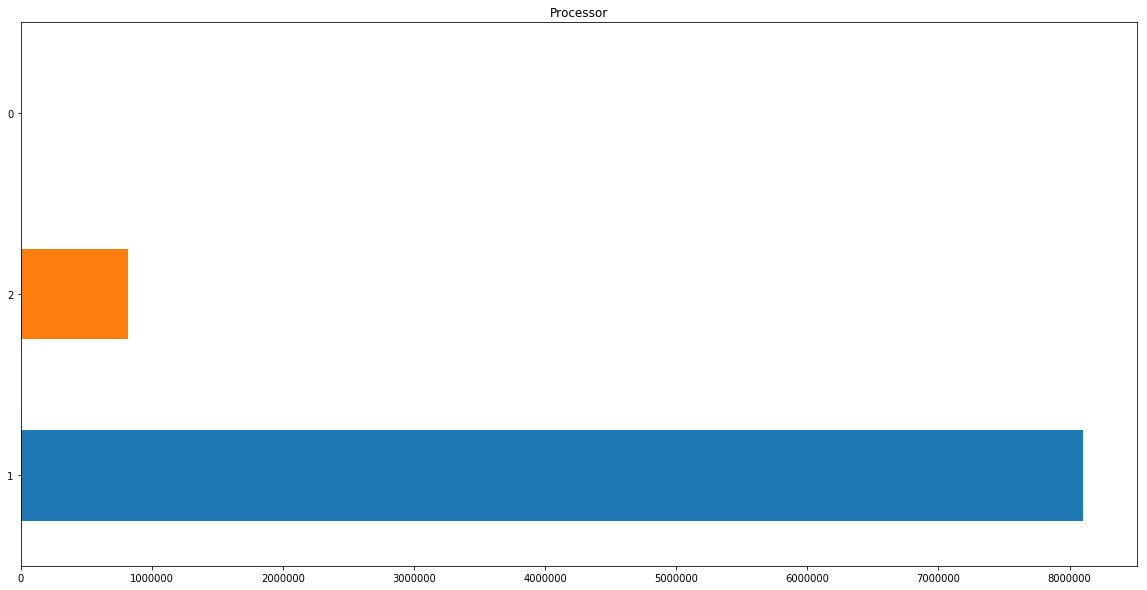

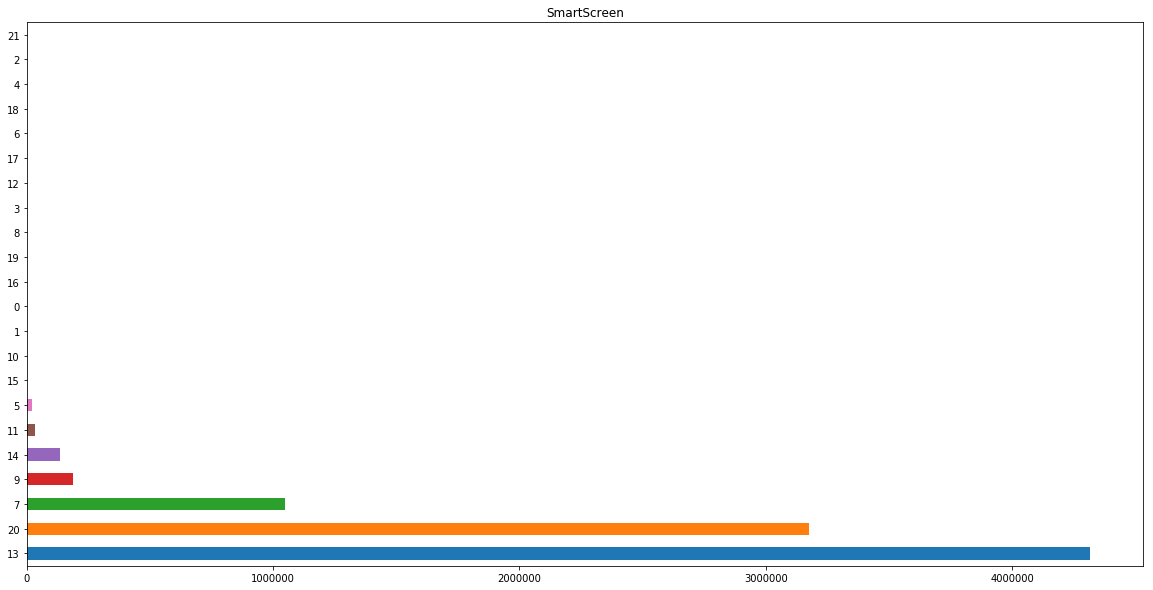

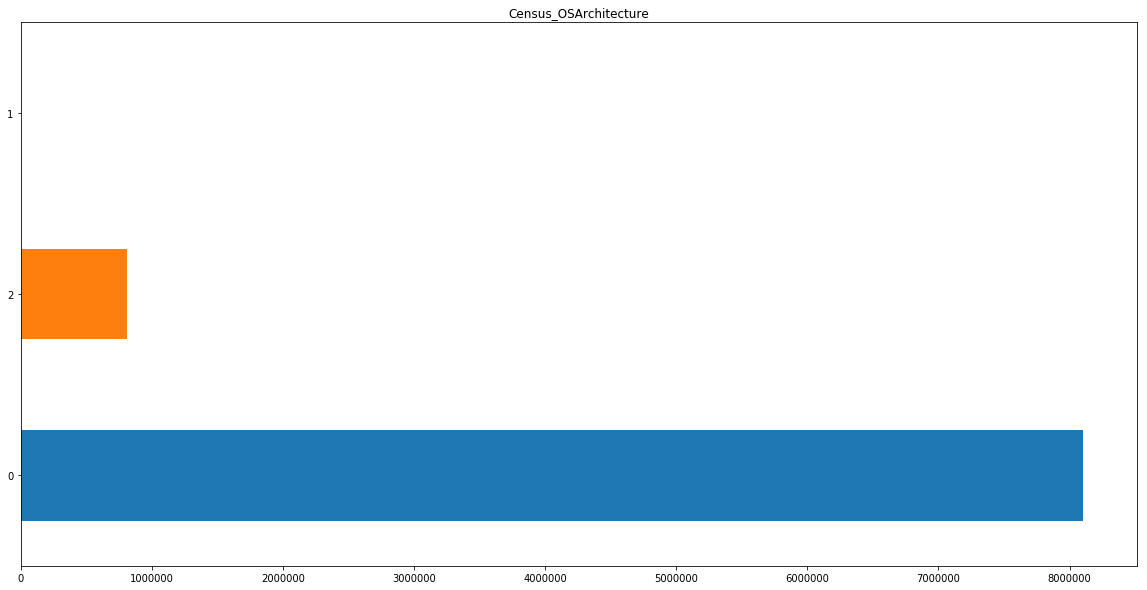

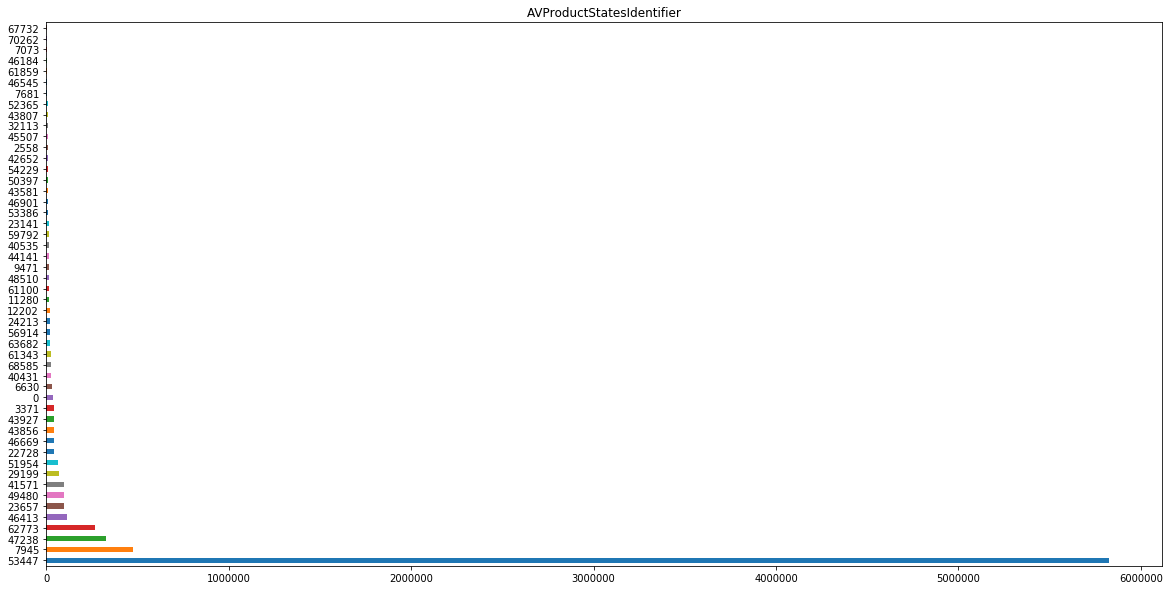

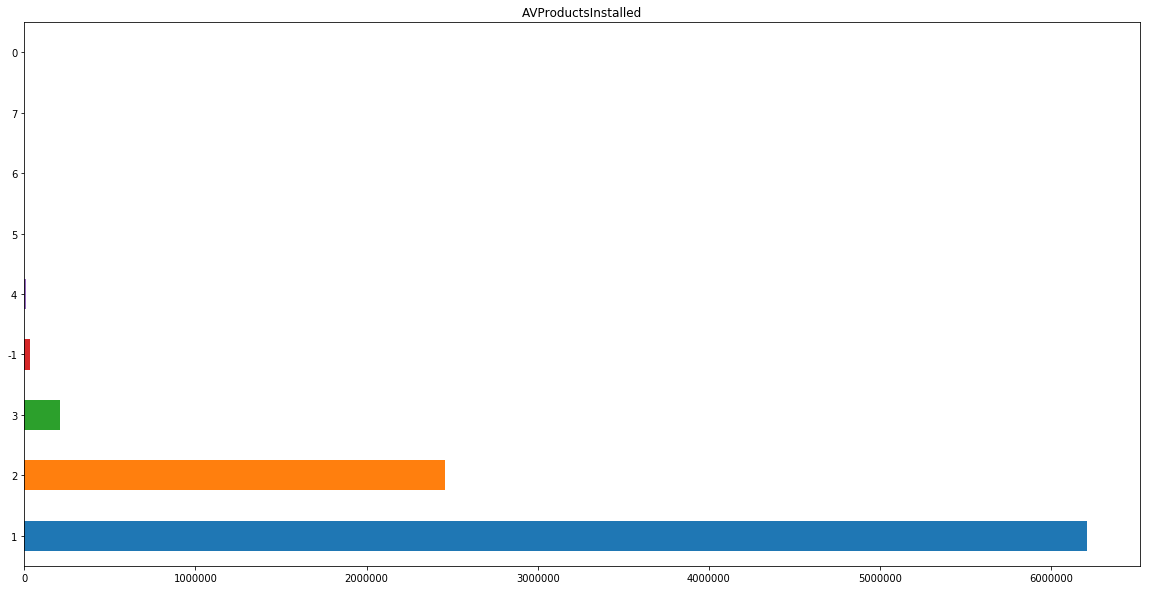

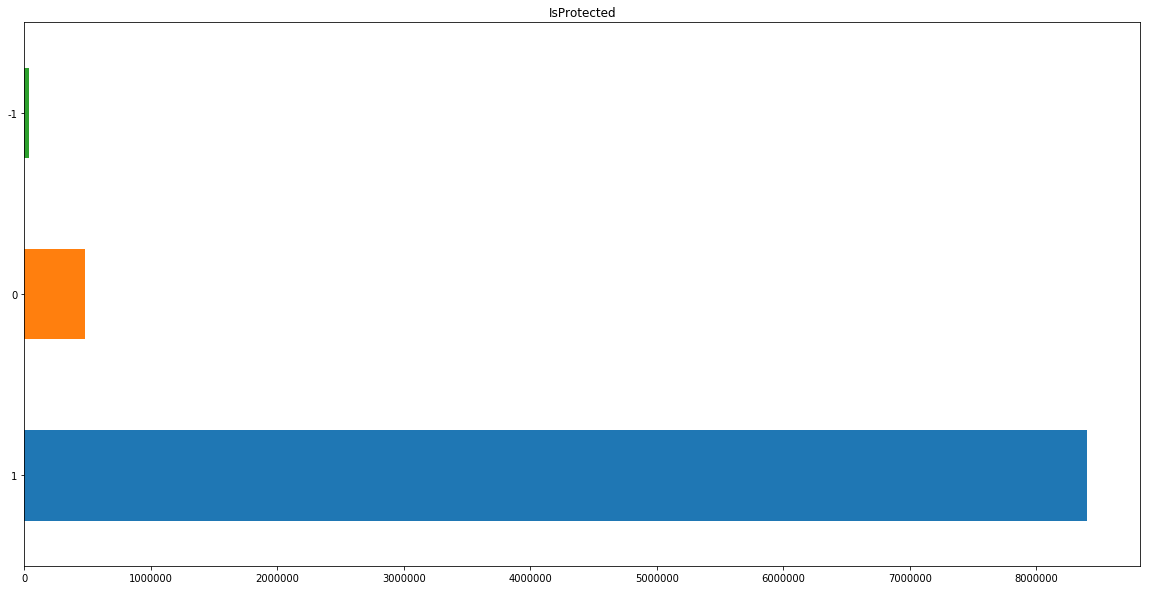

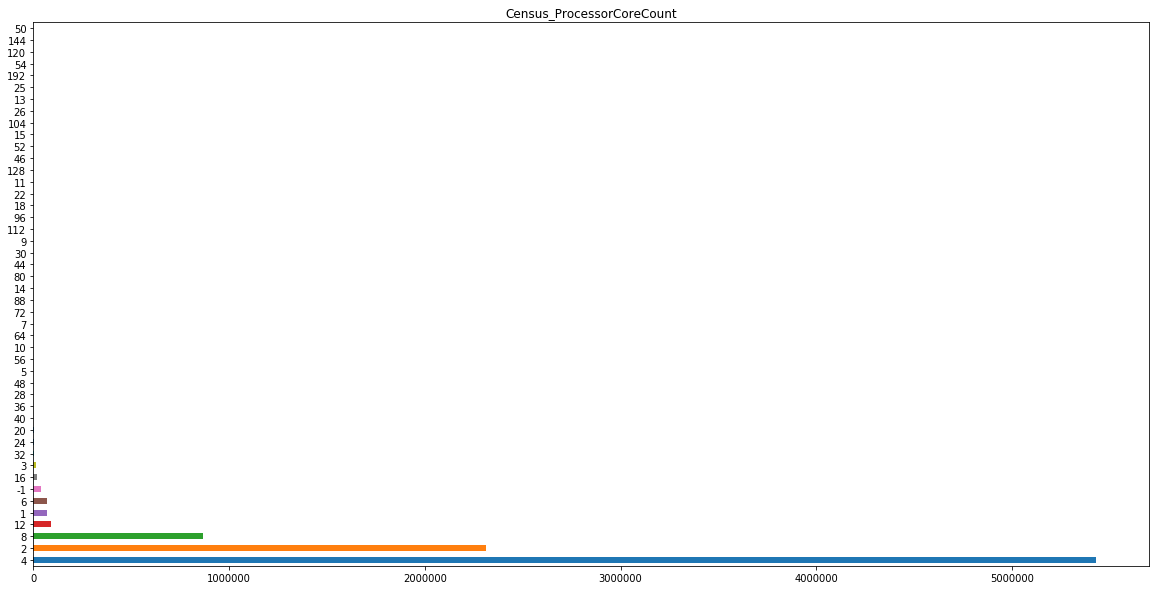

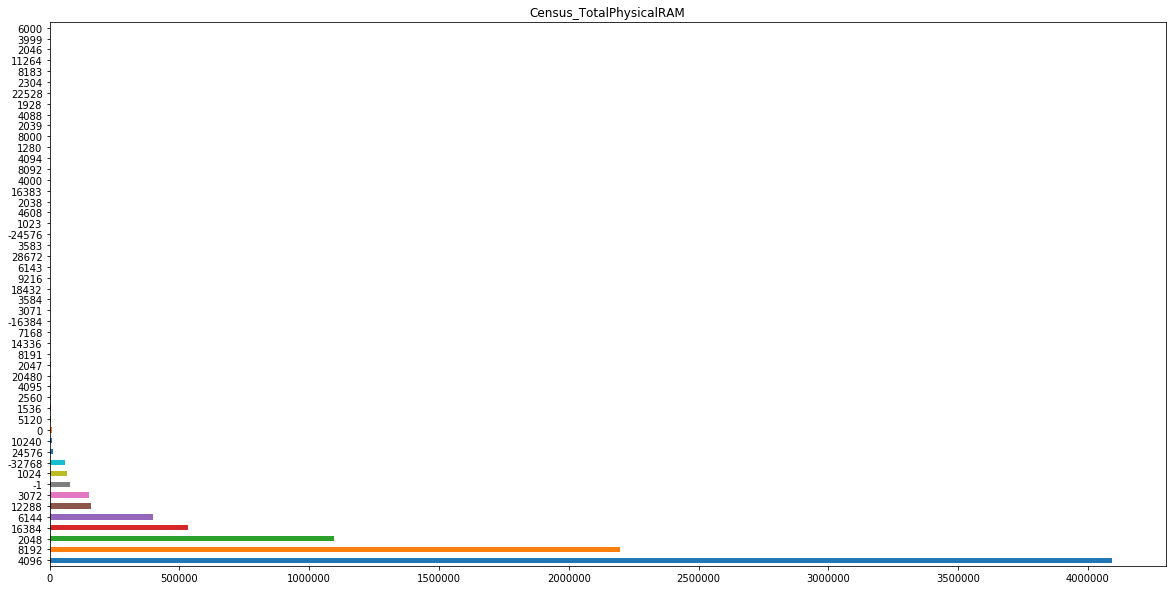

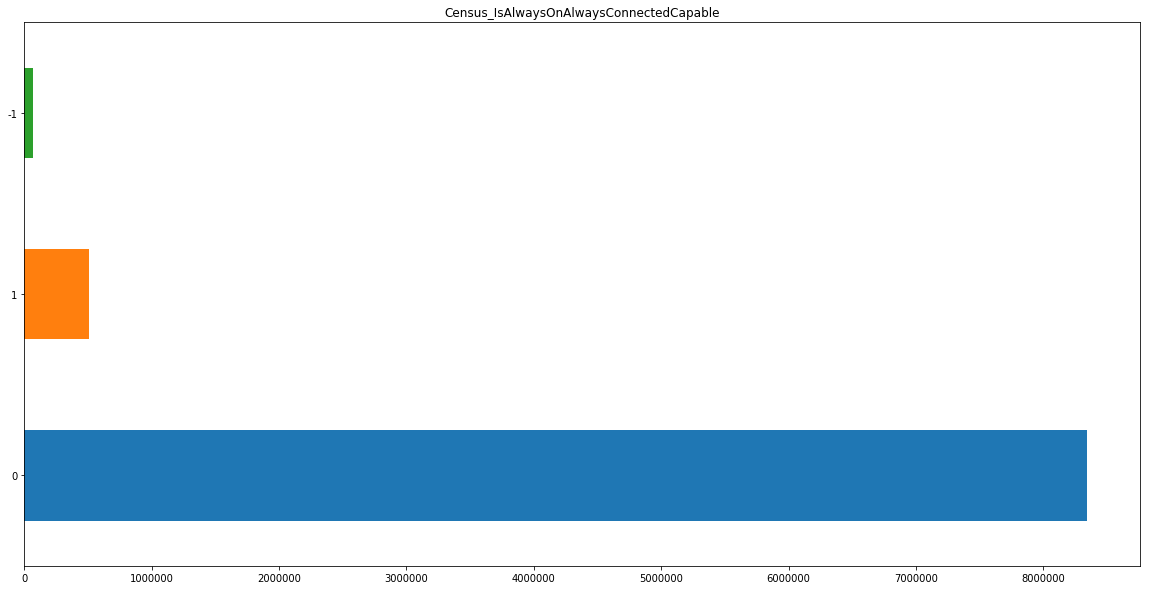

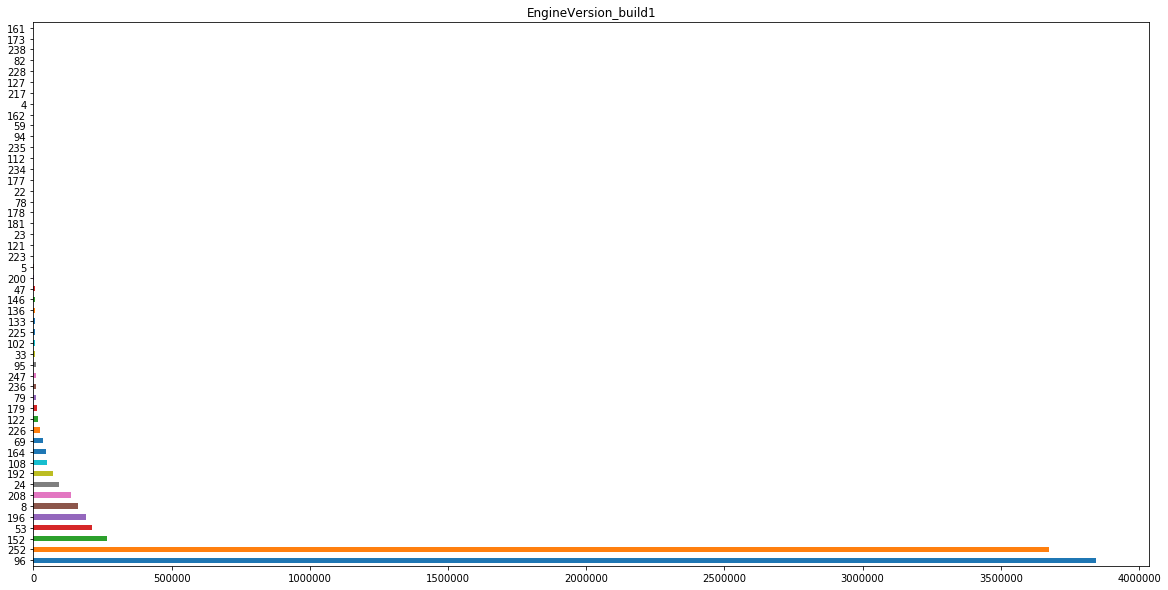

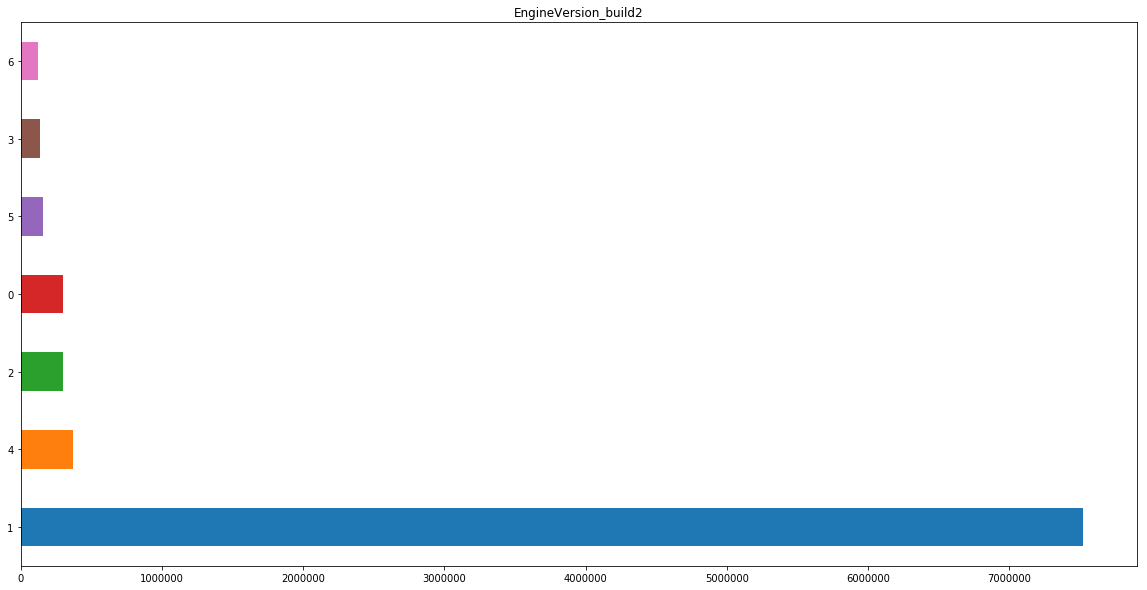

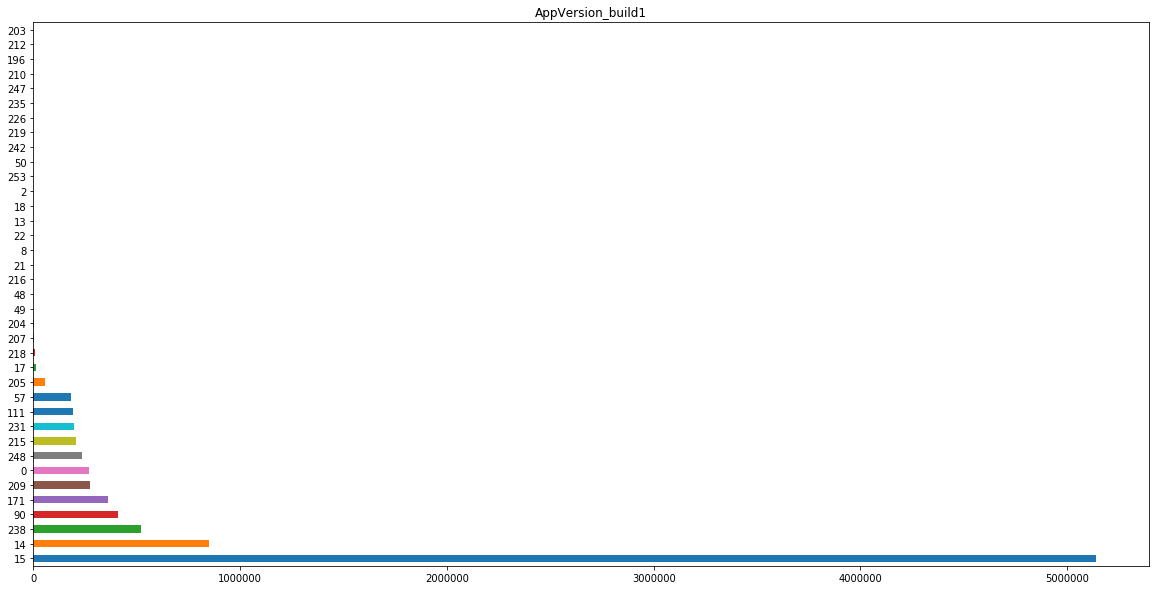

In [91]:
import matplotlib.pyplot as plt

for i, col in enumerate(correlated_cols):
    #count = train_data[col].value_counts(sort=False).sort_values(ascending=False).nlargest(50)
    plt.figure(i)
    train_df[col].value_counts(sort=False).sort_values(ascending=False).nlargest(50).plot(kind='barh', figsize=(20,10), title=col)
    #sns.set(style="darkgrid")
    #sns.barplot(count.index, count.values, alpha=0.9)
    #plt.hist(x=count)
    #plt.figsize=[20,10]
    #plt.title('Frequency Distribution of ' + col )
    #plt.ylabel('Number of Occurrences', fontsize=12)
    #plt.xlabel(col, fontsize=12)
    #plt.show()
    
#    


In [92]:
# function to create new train, test and dev samples pulling data from the training set using random stratification on the outcome variable
from sklearn.model_selection import train_test_split
def generate_train_test_dev_minis(n, features, labels):
    sample_size = n / features.shape[0]
    reserved_size = 1-sample_size
    X_train, X_test_and_dev_and_rest, y_train, y_test_and_dev_and_rest = train_test_split(features, labels, stratify=labels, test_size=reserved_size, random_state=0)
    reserved_size = 1-X_train.shape[0]/X_test_and_dev_and_rest.shape[0]
    X_test, X_dev_and_rest, y_test, y_dev_and_rest = train_test_split(X_test_and_dev_and_rest, y_test_and_dev_and_rest, stratify=y_test_and_dev_and_rest, test_size=reserved_size, random_state=0)
    reserved_size = 1-X_test.shape[0]/X_dev_and_rest.shape[0]
    X_dev, X_rest, y_dev, y_rest = train_test_split(X_dev_and_rest, y_dev_and_rest, stratify=y_dev_and_rest, test_size=reserved_size, random_state=0)
    return X_train, X_test, X_dev, y_train, y_test, y_dev

In [93]:
X_train, X_test, X_dev, y_train, y_test, y_dev = generate_train_test_dev_minis(50000, train_data_corr, train_labels)

In [94]:
print(X_train.shape)
print(X_test.shape)
print(X_dev.shape)

(50000, 12)
(50000, 12)
(50000, 12)


In [95]:
classifier =  KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')

In [96]:
pred_y = classifier.predict(X_test)

In [97]:
results = confusion_matrix(y_test, pred_y)
error = zero_one_loss(y_test, pred_y)

print(results)
print(error)

[[19674  5336]
 [16746  8244]]
0.44164000000000003


In [ ]:
# scratch area below

In [ ]:
#fsel = ske.ExtraTreesClassifier().fit(train_data_corr, train_labels)
#model = SelectFromModel(fsel, prefit=True)
#train_data_new = model.transform(train_data_corr)
#nb_features = train_data_new.shape[1]
#nb_features
#train_data_new